In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
%matplotlib inline
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import tqdm
import xgboost as xgb
import scipy.sparse as scp

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

/home/dima/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def rmse(x,y):
    return np.mean((x - y) ** 2) ** 0.5

## Подготовка данных (urls)

In [3]:
urls_train_df = pd.read_csv('data/url_domain_train', header=None, delimiter='\t')
urls_train_df.columns = ['id', 'url', 'count']
urls_train_df = urls_train_df[['id', 'url']]

In [4]:
urls_train_df.head()

,id,url
0,000000014B60815F65B38258011B6C01,login.rutracker.org
1,000000014B60815F65B38258011B6C01,rutracker.org
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net
3,000000014C03DA2A47AC433A0C755201,czinfo.ru
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru


In [5]:
urls_train_df = pd.DataFrame(urls_train_df.groupby('id')['url'].apply(lambda x: x.tolist()))
urls_train_df['id'] = urls_train_df.index
urls_train_df.index = range(len(urls_train_df))
urls_train_df.columns = ['urls', 'id']

In [6]:
urls_train_df.head()

,urls,id
0,"[id.rambler.ru, mail.rambler.ru, r0.ru]",000000013CB5719C0000A2C90002C101
1,"[1prime.ru, autorambler.ru, chellak.ru, docs.c...",00000001442BE24000001B7D00F50801
2,[bosch-korolev.ru],00000001448580F800003F1B31FB0901
3,"[aptekanizkihcen.ua, colady.ru, gorod.dp.ua, i...",0000000145BDB2FF000157971645E901
4,"[astrorok.ru, diets.ru, edaplus.info, eshzdoro...",000000014602771F0000DB9359714C01


In [7]:
age_train_df = pd.read_csv('data/age_profile_train', header=None, delimiter='\t')
age_train_df.columns = ['id', 'age']

In [8]:
age_train_df.head()

,id,age
0,000000013CB5719C0000A2C90002C101,53
1,00000001442BE24000001B7D00F50801,48
2,00000001448580F800003F1B31FB0901,28
3,0000000145BDB2FF000157971645E901,44
4,000000014602771F0000DB9359714C01,48


In [9]:
train_df = urls_train_df.merge(age_train_df, on='id', how='left')

In [10]:
train_df.tail()

,urls,id,age
118598,[dme.ru],E9B7BDD54E733BDF364DD7B4EF74CFEB,27
118599,"[aif.ru, autochel.ru, chelyabinsk.ru, id.rambl...",E9B9D7D347EB1ACE5AAEEBFCE3FBCE7B,58
118600,"[blog.partisani.ge, li.ru, tvrain.ru]",EBFAC66B4EE3FB96BA5DD7DDE3787FE7,56
118601,"[doctorkirov.ru, drive.ru, extrim-park43.ru, m...",F537AD6B46D31ABFF597EFDFE1BDDE71,31
118602,[samara.drom.ru],F55C7EDB467B9FAE1F97E7DDE1747F6B,35


In [11]:
title_unify_train = pd.read_csv('data/title_unify_train', header=None, delimiter='\t')
title_unify_train.columns = ['id','words','count']
title_unify_train = title_unify_train[['id','words']]

In [12]:
title_unify_train.tail()

,id,words
5850384,0625E40E56FB2B910000054E7CE27501,обозрение политический
5850385,0625E40E56FB2B910000054E7CE27501,обозрение политический страница
5850386,063915F15703D2CD000005362EDFB501,без вложение день заработок интернет рубль
5850387,063915F15703D2CD000005362EDFB501,бесплатный надёжный почта рамблер электронный
5850388,D79FBED94DD35ED75AADEDBC6D1CAFE7,март стих


In [13]:
title_unify_train = pd.DataFrame(title_unify_train.groupby('id')['words'].apply(lambda x: ' '.join(x)))
title_unify_train['id'] = title_unify_train.index
title_unify_train.index = range(len(title_unify_train))
title_unify_train.columns = ['words', 'id']

In [14]:
title_unify_train.head()

,words,id
0,бесплатный надёжный почта рамблер электронный ...,000000013CB5719C0000A2C90002C101
1,24-х 34-х до договор неделя новость предложить...,00000001442BE24000001B7D00F50801
2,авто бош контакт королёв сервис авто бош корол...,00000001448580F800003F1B31FB0901
3,ua втрать війни донбасі за на новини озвучить ...,0000000145BDB2FF000157971645E901
4,black walnut грецкий орех чёрный inmoment ru w...,000000014602771F0000DB9359714C01


In [15]:
train_df = train_df.merge(title_unify_train, on='id', how='left')

In [16]:
train_df.tail()

,urls,id,age,words
118598,[dme.ru],E9B7BDD54E733BDF364DD7B4EF74CFEB,27,NaN
118599,"[aif.ru, autochel.ru, chelyabinsk.ru, id.rambl...",E9B9D7D347EB1ACE5AAEEBFCE3FBCE7B,58,4z7616051a 4z7616051d 4z7616052a allroad arnot...
118600,"[blog.partisani.ge, li.ru, tvrain.ru]",EBFAC66B4EE3FB96BA5DD7DDE3787FE7,56,ru онлайн попка порно секс азербайджан военный...
118601,"[doctorkirov.ru, drive.ru, extrim-park43.ru, m...",F537AD6B46D31ABFF597EFDFE1BDDE71,31,5d merced-benz видео драйв комплектация отзыв ...
118602,[samara.drom.ru],F55C7EDB467B9FAE1F97E7DDE1747F6B,35,NaN


In [17]:
train_df = train_df[['id','urls','words','age']]

In [18]:
train_df.tail()

,id,urls,words,age
118598,E9B7BDD54E733BDF364DD7B4EF74CFEB,[dme.ru],NaN,27
118599,E9B9D7D347EB1ACE5AAEEBFCE3FBCE7B,"[aif.ru, autochel.ru, chelyabinsk.ru, id.rambl...",4z7616051a 4z7616051d 4z7616052a allroad arnot...,58
118600,EBFAC66B4EE3FB96BA5DD7DDE3787FE7,"[blog.partisani.ge, li.ru, tvrain.ru]",ru онлайн попка порно секс азербайджан военный...,56
118601,F537AD6B46D31ABFF597EFDFE1BDDE71,"[doctorkirov.ru, drive.ru, extrim-park43.ru, m...",5d merced-benz видео драйв комплектация отзыв ...,31
118602,F55C7EDB467B9FAE1F97E7DDE1747F6B,[samara.drom.ru],NaN,35


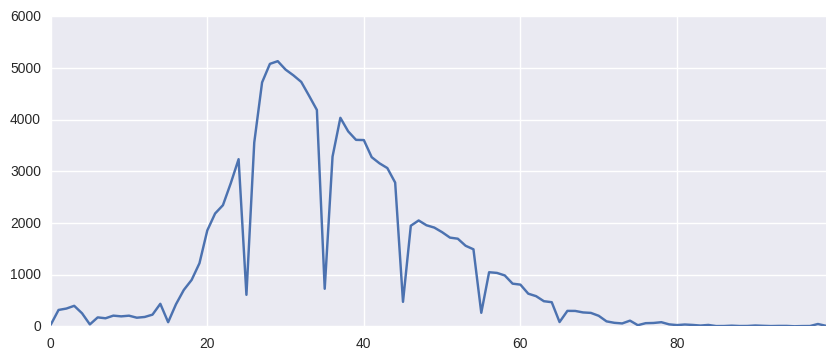

In [29]:
age_count = []
for age in xrange(100):
    age_count += [len(train_df[train_df.age == age])]
pd.Series(age_count).plot(figsize=(10,4))
plt.xlabel = 'возраст'

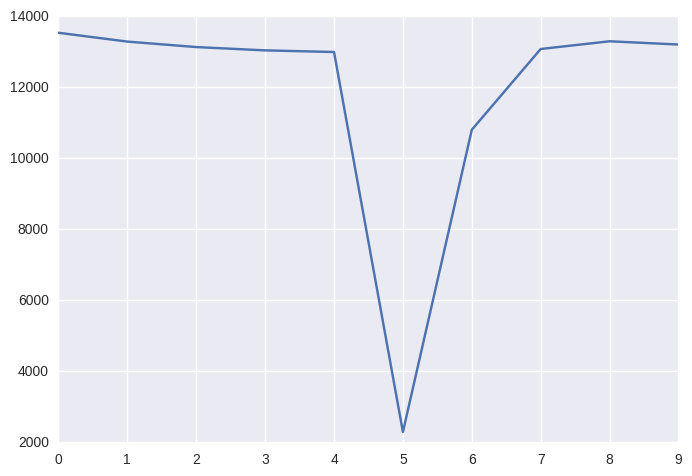

In [21]:
age_count = []
for i in xrange(10):
    age_count += [len(train_df[train_df.age % 10 == i])]
plt.plot(age_count)

In [33]:
train_df[train_df.age % 10 == 5].tail()

,id,urls,words,age
118148,0625E94F5702082200000543EDA15F01,"[anitokyo.tv, consultmill.ru, kakras.ru, mail....",formar terra аниме бесплатно онлайн смотреть т...,25
118257,06323A7556EA742B00000534ED7F9901,"[aktteva.ru, m.rambler.ru, mirtesen.ru, newss....",америка взбесить войско вывод почему будущее в...,45
118368,063905E556DFCF6D00000540B3121801,"[abonentov.net, chat.ru, gazeta.ru, gisclub.tv...",3g usb-модем для интернет мобильный gi прошивк...,55
118488,06392CA75702A7630000054E1849B501,"[d2bingo.ru, id.rambler.ru, mail.rambler.ru, m...",co rambler авторизация d2bingo ru дот испытать...,25
118602,F55C7EDB467B9FAE1F97E7DDE1747F6B,[samara.drom.ru],NaN,35


In [34]:
print(len(train_df[train_df.age >= 65]))
train_df = train_df[train_df.age < 65]

2254


In [35]:
print(len(train_df[train_df.age <= 15]))
train_df = train_df[train_df.age > 15]

3387


In [36]:
train_df.tail()

,id,urls,words,age
118598,E9B7BDD54E733BDF364DD7B4EF74CFEB,[dme.ru],NaN,27
118599,E9B9D7D347EB1ACE5AAEEBFCE3FBCE7B,"[aif.ru, autochel.ru, chelyabinsk.ru, id.rambl...",4z7616051a 4z7616051d 4z7616052a allroad arnot...,58
118600,EBFAC66B4EE3FB96BA5DD7DDE3787FE7,"[blog.partisani.ge, li.ru, tvrain.ru]",ru онлайн попка порно секс азербайджан военный...,56
118601,F537AD6B46D31ABFF597EFDFE1BDDE71,"[doctorkirov.ru, drive.ru, extrim-park43.ru, m...",5d merced-benz видео драйв комплектация отзыв ...,31
118602,F55C7EDB467B9FAE1F97E7DDE1747F6B,[samara.drom.ru],NaN,35


In [37]:
train_df = train_df[train_df.words == train_df.words]

## Снижение размерности

In [38]:
topk = 300000
X_urls, X_title, y = train_df.urls.values[:topk], train_df.words.values[:topk], train_df.age.values[:topk]
y = y - 36
y.size

108573

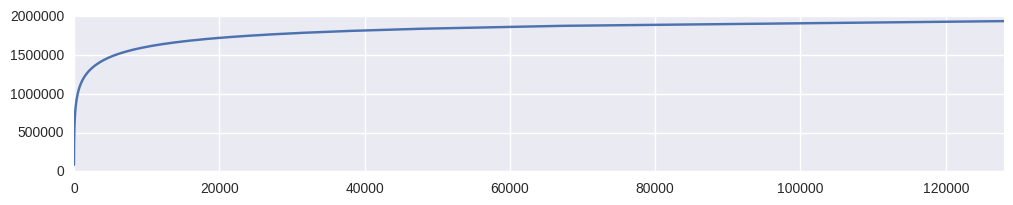

In [28]:
url_frequency = pd.Series([j for i in X_urls for j in i]).value_counts()
url_frequency.index = range(len(url_frequency))
url_frequency.cumsum().plot(figsize=(12,2))

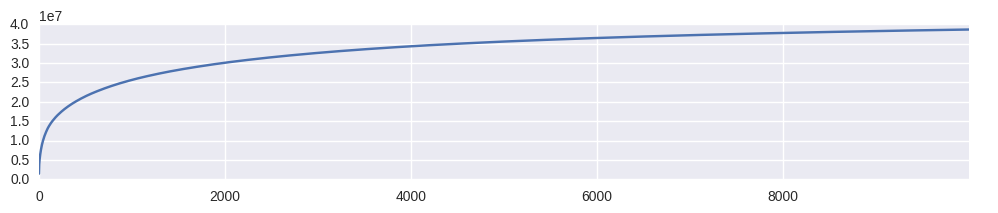

In [35]:
#title_frequency = pd.Series([j for i in X_title for j in i.split()]).value_counts()
#title_frequency.index = range(len(title_frequency))
title_frequency[0:10000].cumsum().plot(figsize=(12,2))

In [39]:
X_urls = map(lambda x: ' '.join(x), X_urls)
hw_u = HashingVectorizer(n_features=1000, non_negative=True).fit(X_urls)
X_urls = hw_u.transform(X_urls)

In [40]:
X_urls.shape

(108573, 1000)

In [41]:
#X_title = map(lambda x: ' '.join(x), X_title)
hw_t = HashingVectorizer(n_features=1500, non_negative=True, decode_error='ignore').fit(X_title)
X_title = hw_t.transform(X_title)
print 1

1


In [42]:
X_title.shape

(108573, 1500)

In [32]:
%%time

transformer = sklearn.decomposition.NMF(n_components=100)
X_nmf = transformer.fit_transform(X_urls)

CPU times: user 36min 53s, sys: 16.8 s, total: 37min 9s
Wall time: 20min 3s


In [33]:
X_nmf.shape

(108573, 100)

In [ ]:
clust = AgglomerativeClustering(5)
clust.fit(X_nmf[:10000]) 

## Холдаут

In [43]:
itrain, itest = cross_validation.train_test_split(range(X_urls.shape[0]), test_size=1./3, random_state=42)
len(itrain), len(itest)

(72382, 36191)

## Обучение модели

Константный бейзлайн

In [44]:
rmse(y[itest], np.mean(y[itrain]))


10.772915115482986

In [45]:
print(min(y),np.mean(y),max(y))


(16, 36.285734022270731, 64)


Линейная модель на обычных фичах

In [67]:
y = train_df.age.values

Линейная модель на NMF от обычных фичей

In [71]:
reg = LinearRegression()
reg.fit(X_nmf[itrain, :], y[itrain])

pred_X_nmf = reg.predict(X_nmf[itest, :])
print(rmse(y[itest], pred_X_nmf))

10.2421827729


In [112]:
reg2 = sklearn.ensemble.ExtraTreesRegressor(n_estimators=100, max_leaf_nodes=10)
reg2.fit(X_title[itrain, :], y[itrain])

print rmse(reg2.predict(X_title[itrain, :]), y[itrain])
pred_X_title = reg2.predict(X_title[itest, :])
print(rmse(y[itest], pred_X_title))

KeyboardInterrupt: 

In [115]:
reg1 = LinearRegression()
reg1.fit(X_urls[itrain, :], y[itrain])

pred_lin_urls = reg1.predict(X_urls[itest, :])
print(rmse(y[itest], pred_X_urls))

10.0981519647


In [116]:
reg3 = LinearRegression()
reg3.fit(X_title[itrain, :], y[itrain])

print rmse(reg3.predict(X_title[itrain, :]), y[itrain])
pred_lin_title = reg3.predict(X_title[itest, :])
print(rmse(y[itest], pred_X_title))

9.82954052364
10.1214757278


Линейная комбинация

9.93450419347
48


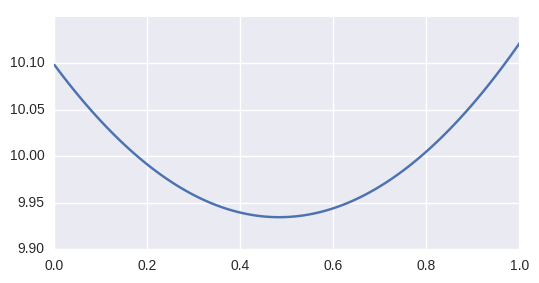

In [117]:
error = []
for w in np.linspace(0, 1, 100):
     error += [rmse(y[itest], pred_lin_title * w + (1-w) * pred_lin_urls)]

pd.Series(error, index=np.linspace(0, 1, 100)).plot(figsize=(6,3))
print(min(error))
print np.argmin(error)

In [139]:
bst_urls = xgb.XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.1, silent = False, reg_lambda=0.05, min_child_weight=100)
bst_urls.fit(X_urls[itrain], y[itrain], 
             eval_set = [(X_urls[itrain], y[itrain]),(X_urls[itest], y[itest])], 
             eval_metric='rmse', verbose=True)

[0]	validation_0-rmse:10.6188	validation_1-rmse:10.6708
[1]	validation_0-rmse:10.5237	validation_1-rmse:10.5851
[2]	validation_0-rmse:10.4443	validation_1-rmse:10.5141
[3]	validation_0-rmse:10.3775	validation_1-rmse:10.4552
[4]	validation_0-rmse:10.3201	validation_1-rmse:10.4058
[5]	validation_0-rmse:10.2721	validation_1-rmse:10.3658
[6]	validation_0-rmse:10.2308	validation_1-rmse:10.3317
[7]	validation_0-rmse:10.195	validation_1-rmse:10.3032
[8]	validation_0-rmse:10.1638	validation_1-rmse:10.2791
[9]	validation_0-rmse:10.1353	validation_1-rmse:10.258
[10]	validation_0-rmse:10.1114	validation_1-rmse:10.2391
[11]	validation_0-rmse:10.0885	validation_1-rmse:10.2234
[12]	validation_0-rmse:10.0688	validation_1-rmse:10.2093
[13]	validation_0-rmse:10.0501	validation_1-rmse:10.1964
[14]	validation_0-rmse:10.0338	validation_1-rmse:10.1865
[15]	validation_0-rmse:10.018	validation_1-rmse:10.1757
[16]	validation_0-rmse:10.0032	validation_1-rmse:10.1657
[17]	validation_0-rmse:9.99039	validation_1-

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=100, missing=None, n_estimators=400, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=0.05,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

In [141]:
print rmse(y[itrain], bst_urls.predict(X_urls[itrain]))
pred_urls = bst_urls.predict(X_urls[itest])

print rmse(y[itest], pred_urls)

9.26921058975
9.94770848737


In [245]:
bst_title = xgb.XGBRegressor(n_estimators=260, max_depth=6, silent = False, reg_lambda=0.05, min_child_weight=100)
bst_title.fit(X_title[itrain], y[itrain], 
            eval_set = [(X_title[itrain], y[itrain]),(X_title[itest], y[itest])], 
            eval_metric='rmse', verbose=True)

print rmse(y[itrain], bst_title.predict(X_title[itrain]))
pred_title = bst_title.predict(X_title[itest])

print rmse(y[itest], pred_title)

[0]	validation_0-rmse:10.6248	validation_1-rmse:10.6798
[1]	validation_0-rmse:10.5369	validation_1-rmse:10.6029
[2]	validation_0-rmse:10.4625	validation_1-rmse:10.541
[3]	validation_0-rmse:10.3956	validation_1-rmse:10.4863
[4]	validation_0-rmse:10.338	validation_1-rmse:10.4405
[5]	validation_0-rmse:10.289	validation_1-rmse:10.4011
[6]	validation_0-rmse:10.2472	validation_1-rmse:10.3701
[7]	validation_0-rmse:10.2099	validation_1-rmse:10.3423
[8]	validation_0-rmse:10.1764	validation_1-rmse:10.3177
[9]	validation_0-rmse:10.1427	validation_1-rmse:10.2944
[10]	validation_0-rmse:10.1117	validation_1-rmse:10.2734
[11]	validation_0-rmse:10.0838	validation_1-rmse:10.2552
[12]	validation_0-rmse:10.0599	validation_1-rmse:10.2409
[13]	validation_0-rmse:10.0384	validation_1-rmse:10.2286
[14]	validation_0-rmse:10.018	validation_1-rmse:10.2165
[15]	validation_0-rmse:10.0008	validation_1-rmse:10.2061
[16]	validation_0-rmse:9.98318	validation_1-rmse:10.1958
[17]	validation_0-rmse:9.96393	validation_1-r

9.84305672804
49


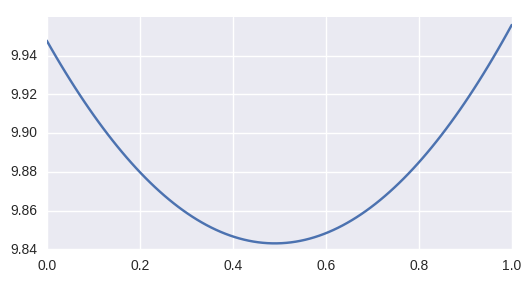

In [188]:
error = []
for w in np.linspace(0, 1, 100):
     error += [rmse(y[itest], pred_title * w + (1-w) * pred_urls)]

pd.Series(error, index=np.linspace(0, 1, 100)).plot(figsize=(6,3))
print(min(error))
print np.argmin(error)

In [223]:
X_title

<108573x1500 sparse matrix of type '<type 'numpy.float64'>'
	with 16587515 stored elements in Compressed Sparse Row format>

In [229]:
X_all = scp.hstack((X_title, X_urls))
X_all = X_all.tocsr()
print X_all.shape

(108573, 2500)


In [230]:
X_all

<108573x2500 sparse matrix of type '<type 'numpy.float64'>'
	with 19189106 stored elements in Compressed Sparse Row format>

In [231]:
lin_reg_all = LinearRegression()
lin_reg_all.fit(X_all[itrain, :], y[itrain])

print rmse(lin_reg_all.predict(X_all[itrain, :]), y[itrain])
pred_lin_all = lin_reg_all.predict(X_all[itest, :])
print(rmse(y[itest], pred_lin_all))

9.57441595303
9.98787427247


In [236]:
bst_bust_all = xgb.XGBRegressor(n_estimators=300, max_depth=6, silent = False, reg_lambda=0.05, min_child_weight=100)
bst_bust_all.fit(X_all[itrain], y[itrain], 
            eval_set = [(X_all[itrain], y[itrain]),(X_all[itest], y[itest])], 
            eval_metric='rmse', verbose=True)

[0]	validation_0-rmse:10.6117	validation_1-rmse:10.6668
[1]	validation_0-rmse:10.5097	validation_1-rmse:10.5771
[2]	validation_0-rmse:10.4252	validation_1-rmse:10.504
[3]	validation_0-rmse:10.3522	validation_1-rmse:10.4434
[4]	validation_0-rmse:10.2902	validation_1-rmse:10.3926
[5]	validation_0-rmse:10.2363	validation_1-rmse:10.349
[6]	validation_0-rmse:10.1875	validation_1-rmse:10.3111
[7]	validation_0-rmse:10.1445	validation_1-rmse:10.2776
[8]	validation_0-rmse:10.107	validation_1-rmse:10.2495
[9]	validation_0-rmse:10.0705	validation_1-rmse:10.2243
[10]	validation_0-rmse:10.0379	validation_1-rmse:10.203
[11]	validation_0-rmse:10.0086	validation_1-rmse:10.183
[12]	validation_0-rmse:9.98341	validation_1-rmse:10.1655
[13]	validation_0-rmse:9.96049	validation_1-rmse:10.1505
[14]	validation_0-rmse:9.93989	validation_1-rmse:10.1368
[15]	validation_0-rmse:9.9209	validation_1-rmse:10.1247
[16]	validation_0-rmse:9.90325	validation_1-rmse:10.1147
[17]	validation_0-rmse:9.88702	validation_1-rms

In [266]:
%%time

transformer = sklearn.decomposition.NMF(n_components=150)
X_nmf = transformer.fit_transform(X_all)

CPU times: user 58min 37s, sys: 15.6 s, total: 58min 53s
Wall time: 53min 19s


In [265]:
extra_trees = ensemble.ExtraTreesRegressor(n_estimators=100)

<108573x2500 sparse matrix of type '<type 'numpy.float64'>'
	with 19189106 stored elements in Compressed Sparse Row format>

In [241]:
print rmse(y[itrain], bst_bust_all.predict(X_all[itrain]))
pred_bust_all = bst_bust_all.predict(X_all[itest])

print rmse(y[itest], pred_bust_all)

8.8722932535
9.82992354026


In [259]:
X_pred = np.vstack((pred_title, pred_urls, pred_lin_title, pred_lin_urls, pred_lin_all, pred_bust_all)).transpose()

In [260]:
stack_reg = LinearRegression()
stack_reg.fit(X_pred, y[itest])

pred_stack = stack_reg.predict(X_pred)
print(rmse(y[itest], pred_stack))

9.7755094266


In [37]:
from sklearn import pipeline, preprocessing, feature_extraction

In [43]:
# %%time

# обычный датасет
dataset1 = Dataset(X_urls[itrain, :], y[itrain], X_urls[itest, :])
# NMF
#dataset2 = Dataset(X_nmf[itrain, :], y[itrain], X_nmf[itest, :])
# датасет тайтлов
dataset3 = Dataset(X_title[itrain, :], y[itrain], X_title[itest, :])

# линейная модель на обычных данных
lr_urls = Regressor(dataset=dataset1, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr_urls')

lr_title = Regressor(dataset=dataset3, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr_title')

# линейная модель на TFIDF от обычных данных
def tfidf_lr_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = pipeline.Pipeline([('tfidf', feature_extraction.text.TfidfTransformer()), 
                                ('linear_model', linear_model.LinearRegression())])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr = Regressor(dataset=dataset1,
                     estimator=tfidf_lr_,
                     name='tfidf_lr')

# ExtraTrees на NMF
#rf = Regressor(dataset=dataset2, 
#                     estimator=ensemble.ExtraTreesRegressor,
#                     parameters={'n_estimators': 100, 'n_jobs': -1},
#                     name='rf')

print 1
# Stack two models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr_urls, lr_title, tfidf_lr, rf)
print 2
stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)

print 3
# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)

print 4
results = stacker.predict()

print(rmse(y[itest], results))

1
2
3
4
10.0017198997


### Делаю файл с предсказанием на тестовой выборке

In [122]:
urls_test_df = pd.read_csv('data/url_domain_test', header=None, delimiter='\t')
urls_test_df.columns = ['id', 'url', 'count']
urls_test_df = urls_test_df[['id', 'url']]
urls_test_df.tail()

,id,url
613383,06258377567D8500000004DF4B0DF601,vashaibolit.ru
613384,06258377567D8500000004DF4B0DF601,xn--80aag2bpgd.xn--p1ai
613385,06258377567D8500000004DF4B0DF601,xn--h1aeghn.xn--p1ai
613386,06258377567D8500000004DF4B0DF601,zoom.cnews.ru
613387,06258377567D8500000004DF4B0DF601,zvenigorod.superjob.ru


In [123]:
urls_test_df = pd.DataFrame(urls_test_df.groupby('id')['url'].apply(lambda x: x.tolist()))
urls_test_df['id'] = urls_test_df.index
urls_test_df.index = range(len(urls_test_df))
urls_test_df.columns = ['urls', 'id']

In [124]:
urls_test_df.tail()

,urls,id
19969,"[akusherstvo.ru, cat.pet2me.com, domik3.ru, ge...",06393B8756FE32ED000004DE11330B01
19970,"[free.drweb.ru, mail.rambler.ru, pevp.mos.ru, ...",06393B87570376CB000004D6801BDC01
19971,"[afisha.ru, formulalubvi.com, gazeta.ru, hh.ru...",06393D555702D3B2000004DE774F1901
19972,"[kirrail.org, lenta.ru, mail.rambler.ru, rambl...",06394267570511A900000540C88F9201
19973,"[help.rambler.ru, mail.rambler.ru, realtymag.r...",0639457C57020EB700006DD1885A0501


In [125]:
title_unify_test = pd.read_csv('data/title_unify_test', header=None, delimiter='\t')
title_unify_test.columns = ['id','words','count']
title_unify_test = title_unify_test[['id','words']]

In [126]:
title_unify_train.tail()

,words,id
114151,chanel афиша киев магазин cl merced для зажига...,E7DB77EB4EEFF6C73DD7EB5CD37CB7E3
114152,cosmopolitan ведущий гламурный гузеев журнал и...,E7DFB7DB4DDF3C7E785EDF7DF17AA76D
114153,4z7616051a 4z7616051d 4z7616052a allroad arnot...,E9B9D7D347EB1ACE5AAEEBFCE3FBCE7B
114154,ru онлайн попка порно секс азербайджан военный...,EBFAC66B4EE3FB96BA5DD7DDE3787FE7
114155,5d merced-benz видео драйв комплектация отзыв ...,F537AD6B46D31ABFF597EFDFE1BDDE71


In [127]:
title_unify_test = pd.DataFrame(title_unify_test.groupby('id')['words'].apply(lambda x: ' '.join(x)))
title_unify_test['id'] = title_unify_test.index
title_unify_test.index = range(len(title_unify_test))
title_unify_test.columns = ['words', 'id']

In [128]:
test_df = urls_test_df.merge(title_unify_test, on='id', how='left')

In [129]:
test_df.tail()

,urls,id,words
19969,"[akusherstvo.ru, cat.pet2me.com, domik3.ru, ge...",06393B8756FE32ED000004DE11330B01,10-метровый бессмертный вечный май москва огон...
19970,"[free.drweb.ru, mail.rambler.ru, pevp.mos.ru, ...",06393B87570376CB000004D6801BDC01,footer бесплатный надёжный почта рамблер элект...
19971,"[afisha.ru, formulalubvi.com, gazeta.ru, hh.ru...",06393D555702D3B2000004DE774F1901,co rambler карьер group retail x5 вакансия гла...
19972,"[kirrail.org, lenta.ru, mail.rambler.ru, rambl...",06394267570511A900000540C88F9201,lenta ru lenta ru война госдума день на отвест...
19973,"[help.rambler.ru, mail.rambler.ru, realtymag.r...",0639457C57020EB700006DD1885A0501,alenka844 rambler ru входящая рамблер-почта ак...


In [130]:
test_df = test_df[['id','urls','words']]
test_df.tail()

,id,urls,words
19969,06393B8756FE32ED000004DE11330B01,"[akusherstvo.ru, cat.pet2me.com, domik3.ru, ge...",10-метровый бессмертный вечный май москва огон...
19970,06393B87570376CB000004D6801BDC01,"[free.drweb.ru, mail.rambler.ru, pevp.mos.ru, ...",footer бесплатный надёжный почта рамблер элект...
19971,06393D555702D3B2000004DE774F1901,"[afisha.ru, formulalubvi.com, gazeta.ru, hh.ru...",co rambler карьер group retail x5 вакансия гла...
19972,06394267570511A900000540C88F9201,"[kirrail.org, lenta.ru, mail.rambler.ru, rambl...",lenta ru lenta ru война госдума день на отвест...
19973,0639457C57020EB700006DD1885A0501,"[help.rambler.ru, mail.rambler.ru, realtymag.r...",alenka844 rambler ru входящая рамблер-почта ак...


In [131]:
test_df = test_df[test_df.words == test_df.words]
len(test_df)

19955

In [132]:
X_urls_test = test_df.urls.values
X_urls_test = map(lambda x: ' '.join(x), X_urls_test)
X_urls_test = hw_u.transform(X_urls_test)

In [151]:
X_title_test = test_df.words.values
X_title_test = hw_t.transform(X_title_test)

In [248]:
X_all_test = scp.hstack((X_title_test, X_urls_test))
X_all_test = X_all_test.tocsr()
print X_all.shape

(108573, 2500)


In [152]:
X_title_test.shape

(19955, 1500)

In [251]:
X_pred_test = np.vstack((bst_title.predict(X_title_test), bst_urls.predict(X_urls_test),
                         reg3.predict(X_title_test), reg1.predict(X_urls_test),
                        lin_reg_all.predict(X_all_test), bst_bust_all.predict(X_all_test))).transpose()

In [252]:
y_test = stack_reg.predict(X_pred_test)

In [253]:
y_test += 36

In [254]:
y_test

array([ 46.47048424,  42.66802345,  37.25292536, ...,  37.25190454,
        39.19779586,  39.39158258])

In [ ]:
X_test_nmf = transformer.transform(X_test)

In [ ]:
y_test = reg.predict(X_test_nmf)

In [ ]:
y_test

46.4704842356
['1000bankov.ru', '1tv.ru', '4put.ru', 'argumenti.ru', 'avmalgin.livejournal.com', 'baikalvisa.ru', 'blog.irr.ru', 'cbslibrary5.blogspot.ca', 'club.foto.ru', 'cmd-online.ru', 'cult-turist.ru', 'doseng.org', 'dp.ru', 'dvkapital.ru', 'eadaily.com', 'eda.ru', 'edimdoma.ru', 'eg.ru', 'expert.ru', 'family.rambler.ru', 'film.ru', 'filmi-hd.ru', 'finance.rambler.ru', 'fishki.net', 'forum.ixbt.com', 'forums.drom.ru', 'gazeta.ru', 'gotovim-doma.ru', 'govoritmoskva.ru', 'grani.ru', 'hockey-world.net', 'inforeactor.ru', 'inmoment.ru', 'interfax.ru', 'katebor.com', 'keddr.com', 'kino-teatr.ru', 'kommersant.ru', 'kp.ru', 'lady-forever.ru', 'lenta.ru', 'letaet.livejournal.com', 'livejournal.com', 'livenews.cz', 'love-is.ru', 'lyrics.mp3s.ru', 'm24.ru', 'mail.rambler.ru', 'meddaily.ru', 'megogo.net', 'minivideospectr.ru', 'mk.ru', 'nearyou.ru', 'news.rambler.ru', 'news.smi2.ru', 'newsru.co.il', 'pevp.mos.ru', 'pfrf.ru', 'philologist.livejournal.com', 'potsreotizm.livejournal.com', 'pova

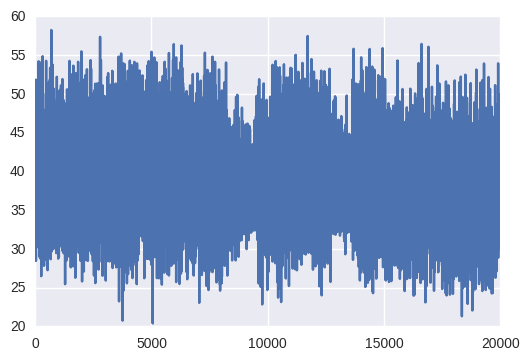

In [255]:
k = 0
print(y_test[k])
print(urls_test_df.urls[k])
plt.plot(y_test)

In [256]:
answer = pd.DataFrame(y_test, test_df.id)
answer['Id'] = answer.index
answer.index = range(len(answer))
answer.columns = ['age', 'Id']
answer = answer[['Id', 'age']]
answer.tail()

,Id,age
19950,06393B8756FE32ED000004DE11330B01,38.293626
19951,06393B87570376CB000004D6801BDC01,37.015728
19952,06393D555702D3B2000004DE774F1901,37.251905
19953,06394267570511A900000540C88F9201,39.197796
19954,0639457C57020EB700006DD1885A0501,39.391583


In [ ]:
answer.to_csv(path_or_buf = 'submission1.csv',  index = False)

In [257]:
aaa = pd.read_csv('data/sample_submission.csv')
Set = set(aaa.Id.values)

Set2 = set(answer.Id.values)

dop = pd.DataFrame([[i,36] for i in (Set - Set2)], columns = ['Id','age'])

answer.append(dop).to_csv(path_or_buf = 'submission1.csv',  index = False)

In [163]:
0.17371*365

63.40415